# Load Data: Phishing Mail
link https://huggingface.co/datasets/zefang-liu/phishing-email-dataset


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
# Load data (source: https://huggingface.co/datasets/zefang-liu/phishing-email-dataset)


df = pd.read_csv("hf://datasets/zefang-liu/phishing-email-dataset/Phishing_Email.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [ ]:
df.shape

(18650, 3)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')

# Preprocesing data

In [ ]:

# Check column names
print("\n📋 Columns:", df.columns.tolist())

# Check for missing values
print("\n🔍 Missing values:\n", df.isnull().sum())

# Check class distribution
print("\n⚖️ Class distribution:")
print(df['Email Type'].value_counts(normalize=True) * 100)

# Check for duplicates
print("\n🔍 Duplicated rows:", df.duplicated().sum())

# Check unique ID consistency
print("\n🔎 Unique Email No.:", df['Unnamed: 0'].nunique(), "/", len(df))


📋 Columns: ['Unnamed: 0', 'Email Text', 'Email Type']

🔍 Missing values:
 Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

⚖️ Class distribution:
Email Type
Safe Email        60.707775
Phishing Email    39.292225
Name: proportion, dtype: float64

🔍 Duplicated rows: 0

🔎 Unique Email No.: 18650 / 18650


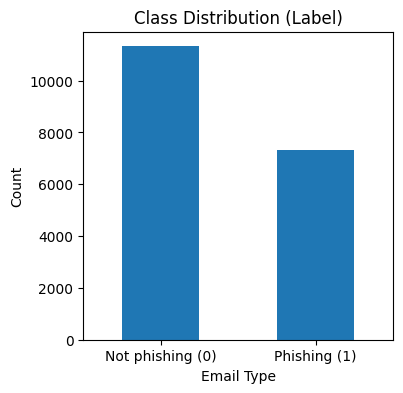

In [ ]:
# Optional: visualize class distribution
plt.figure(figsize=(4,4))
df['Email Type'].value_counts().plot(kind='bar', title='Class Distribution (Label)')
plt.xticks(ticks=[0, 1], labels=['Not phishing (0)', 'Phishing (1)'], rotation=0)
plt.ylabel("Count")
plt.show()

In [ ]:
# Check phishing email
df['Email Type'].value_counts()

,count
Email Type,
Safe Email,11322
Phishing Email,7328


In [ ]:
# Remove rows where Email Text is missing
df_clean = df.dropna(subset=['Email Text'])

In [ ]:
df_clean.isnull().sum()


,0
Unnamed: 0,0
Email Text,0
Email Type,0


In [ ]:
# Drop first column
df_clean = df_clean.drop(columns= 'Unnamed: 0',axis=1)

In [ ]:
# Check for Placeholder Text (like 'empty')
placeholder_count = (df_clean['Email Text'].str.lower() == 'empty').sum()
print(f"Rows with 'empty' as placeholder: {placeholder_count}")


Rows with 'empty' as placeholder: 533


In [ ]:
# Drop empty values
df_clean = df_clean[df_clean['Email Text'].str.lower() != 'empty']

In [ ]:
# Check for Truly Empty Strings
empty_string_count = (df_clean['Email Text'] == '').sum()
print(f"Empty strings (''): {empty_string_count}")

Empty strings (''): 0


In [ ]:
# Binary numeric values
df_clean['Email Type'] = df_clean['Email Type'].map({'Safe Email' :1 ,'Phishing Email' : 0})

#  Define features (X) and target (y)
X = df_clean[['Email Text']]  #  text as features
y = df_clean['Email Type']   # target for stratification


In [ ]:

# Perform 70-30 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [ ]:
# Combine X and y for convenient inspection
train_df = X_train.copy()
train_df['Label'] = y_train

test_df = X_test.copy()
test_df['Label'] = y_test

print("\nFinal splits:")
print("Train:", train_df.shape)
print("Test:", test_df.shape)




Final splits:
Train: (12670, 2)
Test: (5431, 2)


In [ ]:
# Save files
#train_df.to_csv("Data/train.csv", index=False)
#test_df.to_csv("Data/test.csv", index=False)

# BERT Evaluation

In [ ]:
import re

def clean_email_text(text):
    if isinstance(text, str):
        # Normalize whitespace characters
        text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
        text = re.sub(r'\s+', ' ', text)

        # Mask email addresses
        text = re.sub(r'\b[\w.-]+?@\w+?\.\w+?\b', ' [EMAIL] ', text)

        # Mask URLs
        text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

        # Replace long numbers (IDs or phone numbers)
        text = re.sub(r'\d{5,}', ' [NUM] ', text)

        # Remove repeated punctuation like "!!!" or "??"
        text = re.sub(r'([!?.]){2,}', r'\1', text)

        # Remove unwanted characters but keep certain punctuations
        allowed_chars = r'[^\w\s\[\].,!?@-]'
        text = re.sub(allowed_chars, '', text)

        # Convert to lowercase and trim
        return text.strip().lower()

    return ""

# Apply the function
#df['clean_text'] = df['Email Text'].map(clean_email_text) for entire dataset
X_train['clean_text'] = X_train['Email Text'].map(clean_email_text)
X_test['clean_text'] = X_test['Email Text'].map(clean_email_text)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
model.eval()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")
# Batched embedding function
def get_embeddings_batched(texts, batch_size=32):
    all_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        # Tokenize with padding and truncation
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Mean pool across tokens for each sequence
        last_hidden = outputs.last_hidden_state  # shape: [batch_size, seq_len, hidden_size]
        batch_embeddings = last_hidden.mean(dim=1).cpu().numpy()  # shape: [batch_size, hidden_size]

        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)

# Apply to your DataFrame
train_texts = X_train['clean_text'].tolist()
test_texts = X_test['clean_text'].tolist()

train_embeddings = get_embeddings_batched(train_texts)
test_embeddings = get_embeddings_batched(test_texts)

Using device: cuda


100%|██████████| 170/170 [03:05<00:00,  1.09s/it]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

model = RandomForestClassifier()
model.fit(train_embeddings, y_train)

y_pred = model.predict(test_embeddings)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2093
           1       0.96      0.98      0.97      3338

    accuracy                           0.96      5431
   macro avg       0.96      0.96      0.96      5431
weighted avg       0.96      0.96      0.96      5431



# Transformer all-MiniLM-L6-v2

In [ ]:
from sentence_transformers import SentenceTransformer

model_transformer = SentenceTransformer('all-MiniLM-L6-v2')  # fast + good quality
train_embeddings2 = model_transformer.encode(X_train['clean_text'].tolist(), show_progress_bar=True)
test_embeddings2 = model_transformer.encode(X_test['clean_text'].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/396 [00:00<?, ?it/s]

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

rfc = RandomForestClassifier()
rfc.fit(train_embeddings2, y_train)

y_pred = rfc.predict(test_embeddings2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      2093
           1       0.92      0.98      0.95      3338

    accuracy                           0.94      5431
   macro avg       0.95      0.93      0.94      5431
weighted avg       0.94      0.94      0.94      5431



# ROberta

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("songhieng/roberta-phishing-content-detector-4.0")
print(model.config.id2label)


{0: 'LABEL_0', 1: 'LABEL_1'}


In [ ]:
phishing_text = "We noticed suspicious activity on your account. Please reset your password here: http://fake-site.com"
safe_text = "Hi John, just confirming our meeting for tomorrow. Regards."

print("Phishing test →", pipe(phishing_text))
print("Safe test →", pipe(safe_text))


Phishing test → [[{'label': 'LABEL_1', 'score': 0.9997847676277161}]]
Safe test → [[{'label': 'LABEL_0', 'score': 0.9999346733093262}]]


In [ ]:
# 2. Import necessary libraries
from transformers import pipeline
from sklearn.metrics import f1_score, classification_report

# 3. Load pre-trained spam classification model
pipe = pipeline("text-classification", model="songhieng/roberta-phishing-content-detector-4.0", top_k=1)

# 4. Get your input emails (X_test already defined)
texts = X_test["clean_text"].tolist()

# 5. Run the classifier on all test emails
raw_preds = pipe(texts, truncation=True, padding=True)




Device set to use cuda:0


In [ ]:
# 6. Convert labels to integers
label_map = {"LABEL_0": 1, "LABEL_1": 0}
pred_labels = [label_map[pred[0]['label']] for pred in raw_preds]

# 7. Evaluate predictions
true_labels = y_test.values
print("Classification Report:")
print(classification_report(true_labels, pred_labels))
print("F1 Score:", f1_score(true_labels, pred_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2093
           1       0.94      0.95      0.94      3338

    accuracy                           0.93      5431
   macro avg       0.93      0.93      0.93      5431
weighted avg       0.93      0.93      0.93      5431

F1 Score: 0.9445689526370835
